# Multiperiod job search
Flow utility: $w$ if employed
$b_1$ if unemployed for less than $T$ periods (months)
$b_2<b_1$ afterwards with same Markov process

$T+2$ States:
1. employed
2. 1, 2, ..., T months unemployed
3. any longer unemployed

Parametric job search function:
pay $c$, find a job with prob $1-\exp(-\lambda c)$

full Bellman in month $t$ unemployed
$$
v_t = \max_c b_1 - c 
+ \beta[(1-\exp(-\lambda c))v_e + 
\exp(-\lambda c) v_{t+1}]
$$
$$
v_{T+1}= 
\max_c b_2 - c 
+ \beta[(1-\exp(-\lambda c))v_e + 
\exp(-\lambda c) v_{T+2}]
$$
with $v_{T+1} = v_{T+2}=...$ "a" solution
$$
v_e = w + \beta [
(1-\mu)v_e
+ \mu v_1]
$$

> Aside: what if search cost is linear?
> Pr = $\lambda c$?

Maximization FOC
$$
\beta\lambda \exp(-\lambda c)[v_e - v_{t+1}] = 1
$$
$$
\exp(+\lambda c_t) = 
\beta \lambda (v_e-v_{t+1})
$$
$$
c_t = \frac1\lambda [
\ln(\beta \lambda)
+\ln(v_e - v_{t+1})] \tag{**}
$$
if interior, 0 otherwise

Transition matrix
$$
\mathbf P=
\begin{bmatrix}
0 & 1-\pi_1 & 0 & 0 & ... & \pi_1\\
0 & 0 & 1-\pi_2  & 0 & ...& \pi_2\\
...\\
0 & 0 & 0& 0& 1-\pi_{T+1} & \pi_{T+1}\\
\mu &0&0&0&0&1-\mu
\end{bmatrix}
$$
with $\pi_t = 1-\exp(-\lambda c_t)$


In [1]:
λ = 0.1
c = collect(0:0.1:100)

1001-element Vector{Float64}:
   0.0
   0.1
   0.2
   0.3
   0.4
   0.5
   0.6
   0.7
   0.8
   0.9
   1.0
   1.1
   1.2
   ⋮
  98.9
  99.0
  99.1
  99.2
  99.3
  99.4
  99.5
  99.6
  99.7
  99.8
  99.9
 100.0

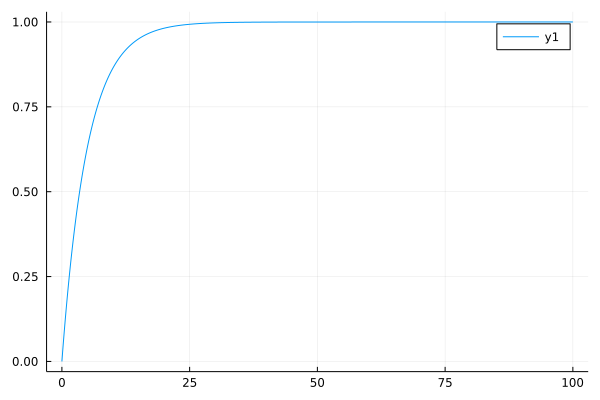

In [2]:
using Plots
plot(c, 1 .- exp.(-2*λ*c))

In [3]:
function P_from_probs(π::Vector{Float64})::Matrix{Float64}
    T = length(π) - 2
    P = zeros(Float64, T+2, T+2)

    # better notation
    e = T+2
    μ = 1 - π[e]
    
    # early unemploymnet months
    for t = 1:T
        P[t, t+1] = 1 - π[t]
        P[t, e] = π[t]
    end
    # long-term unemp
    P[T+1, T+1] = 1 - π[T+1]
    P[T+1, e] = π[T+1]
    # employment
    P[e, 1] = μ
    P[e, e] = 1 - μ
    return P
end

P_from_probs (generic function with 1 method)

In [4]:
P = P_from_probs([0.1, 0.1, 0.3, 0.9])

4×4 Matrix{Float64}:
 0.0  0.9  0.0  0.1
 0.0  0.0  0.9  0.1
 0.0  0.0  0.7  0.3
 0.1  0.0  0.0  0.9

In [5]:
using LinearAlgebra
eigen(P')

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
 -0.14278788723707442
  0.2624336376688149
  0.48035424956825945
  1.0
vectors:
4×4 Matrix{Float64}:
  0.106556  -0.120035  -0.107506  0.0957387
 -0.67163   -0.411653  -0.201426  0.0861648
  0.717223   0.8467     0.825342  0.258495
 -0.152149  -0.315012  -0.516411  0.957387

In [6]:
struct MCDP_without_optimization
    u::Vector{Real}
    β::Real
    P::Matrix{Real}
end

In [7]:
using LinearAlgebra: I
function solve(problem::MCDP_without_optimization)
    return (I - problem.β*problem.P) \ problem.u
end

solve (generic function with 1 method)

In [8]:
v = solve(MCDP_without_optimization([0.3, 0.3, 0.0, 1.0], 0.995, P))

4-element Vector{Float64}:
 142.84966698528413
 143.00842633573112
 143.1857120425396
 145.58413267976806

In [9]:
struct JobSearchProblem
    β::Real
    λ::Real
    μ::Real
    wage::Real
    short_term_benefit::Real
    long_term_benefit::Real
end

In [16]:
function optimize_search(problem::JobSearchProblem, v::Vector{Float64})
    T = length(v) - 2
    c = zeros(T+1)
    e = T+2
    
    λ = problem.λ
    β = problem.β
    
    for t = 1:T
        if v[e] > v[t+1]
            c[t] = max(0, 1/λ *(log(β*λ)+log(v[e] - v[t+1])))
        else
                c[t] = 0
        end
    end
    c[T+1] = c[T]
    return c
end

optimize_search (generic function with 1 method)

In [57]:
multi_period_search = JobSearchProblem(0.995, 0.05, 0.01, 1.0, 0.6, 0.3)
optimize_search(multi_period_search, [1.0, 1.0, 0.9, 20.0])

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [11]:
maximum([0, 1])

1

In [12]:
max([0, 1])

LoadError: MethodError: no method matching max(::Vector{Int64})
[0mClosest candidates are:
[0m  max(::Any, [91m::Missing[39m) at missing.jl:130
[0m  max(::Any, [91m::Any[39m) at operators.jl:419
[0m  max(::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any...[39m) at operators.jl:560
[0m  ...

In [39]:
function iterate(c::Vector{Float64}, problem::JobSearchProblem)
    T = length(c) - 1
    π = 1 .- exp.(-problem.λ .* c)
    append!(π, 1 - problem.μ)
    P = P_from_probs(π)
    u = vcat([problem.short_term_benefit for t=1:T] .- c[1:T], problem.long_term_benefit - c[T+1], problem.wage)
    v = solve(MCDP_without_optimization(u, problem.β, P))
    return optimize_search(problem, v)
end

iterate (generic function with 1 method)

In [29]:
# list comprehension
[1.2 for t = 1:4]

4-element Vector{Float64}:
 1.2
 1.2
 1.2
 1.2

In [30]:
[t^2 for t = 1:5]

5-element Vector{Int64}:
  1
  4
  9
 16
 25

In [31]:
vcat([1, 2, 3], [5, 6, 7])

6-element Vector{Int64}:
 1
 2
 3
 5
 6
 7

In [33]:
vcat([1, 2, 3], 4, 5)

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [27]:
?MCDP_without_optimization

search: MCDP_without_optimization



No documentation found.

# Summary

```
struct MCDP_without_optimization <: Any
```

# Fields

```
u :: Vector{Real}
β :: Real
P :: Matrix{Real}
```


In [20]:
b = [1, 2, 3]

3-element Vector{Int64}:
 1
 2
 3

In [26]:
append!(b, 4)

7-element Vector{Int64}:
 1
 2
 3
 4
 4
 4
 4

In [40]:
c = iterate([0.0, 0.0, 0.0], multi_period_search)

3-element Vector{Float64}:
 15.408693053895867
 15.47242667669805
 15.47242667669805

In [41]:
job_finding_probs = 1 .- exp.(-multi_period_search.λ .* c)

3-element Vector{Float64}:
 0.7858051802403584
 0.7871659803828066
 0.7871659803828066

In [52]:
function solve(problem::JobSearchProblem, T=6, tol=1e-6, maxiter=1e+5)
    policy = zeros(T+1)
    for t = 1:maxiter
        println(t)
        old_policy = copy(policy)
        policy = iterate(old_policy, problem)
        maximum(abs, policy .- old_policy) < tol && break
    end
    return policy
end

solve (generic function with 5 methods)

In [58]:
c = solve(multi_period_search, 6)
job_finding_probs = 1 .- exp.(-multi_period_search.λ .* c)

1.0
2.0
3.0
4.0
5.0
6.0
7.0


7-element Vector{Float64}:
 0.12654783104646428
 0.132393981537138
 0.13909476012235134
 0.14682197974123745
 0.15579525339273448
 0.16629967394732292
 0.16629967394732292

In [49]:
# Array assignment is only by referwnce
a = [1, 2, 3]
b = a
b[3] = 4
a

3-element Vector{Int64}:
 1
 2
 4

In [50]:
# unless we create a copy
a = [1, 2, 3]
b = copy(a)
b[3] = 4
a

3-element Vector{Int64}:
 1
 2
 3

In [51]:
?maximum

search: maximum maximum!



```
maximum(f, itr; [init])
```

Returns the largest result of calling function `f` on each element of `itr`.

The value returned for empty `itr` can be specified by `init`. It must be a neutral element for `max` (i.e. which is less than or equal to any other element) as it is unspecified whether `init` is used for non-empty collections.

!!! compat "Julia 1.6"
    Keyword argument `init` requires Julia 1.6 or later.


# Examples

```jldoctest
julia> maximum(length, ["Julion", "Julia", "Jule"])
6

julia> maximum(length, []; init=-1)
-1

julia> maximum(sin, Real[]; init=-1.0)  # good, since output of sin is >= -1
-1.0
```

---

```
maximum(itr; [init])
```

Returns the largest element in a collection.

The value returned for empty `itr` can be specified by `init`. It must be a neutral element for `max` (i.e. which is less than or equal to any other element) as it is unspecified whether `init` is used for non-empty collections.

!!! compat "Julia 1.6"
    Keyword argument `init` requires Julia 1.6 or later.


# Examples

```jldoctest
julia> maximum(-20.5:10)
9.5

julia> maximum([1,2,3])
3

julia> maximum(())
ERROR: ArgumentError: reducing over an empty collection is not allowed
Stacktrace:
[...]

julia> maximum((); init=-Inf)
-Inf
```

---

```
maximum(A::AbstractArray; dims)
```

Compute the maximum value of an array over the given dimensions. See also the [`max(a,b)`](@ref) function to take the maximum of two or more arguments, which can be applied elementwise to arrays via `max.(a,b)`.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Matrix{Int64}:
 1  2
 3  4

julia> maximum(A, dims=1)
1×2 Matrix{Int64}:
 3  4

julia> maximum(A, dims=2)
2×1 Matrix{Int64}:
 2
 4
```

---

```
maximum(f, A::AbstractArray; dims)
```

Compute the maximum value from of calling the function `f` on each element of an array over the given dimensions.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Matrix{Int64}:
 1  2
 3  4

julia> maximum(abs2, A, dims=1)
1×2 Matrix{Int64}:
 9  16

julia> maximum(abs2, A, dims=2)
2×1 Matrix{Int64}:
  4
 16
```


Theoretical results about PFI?

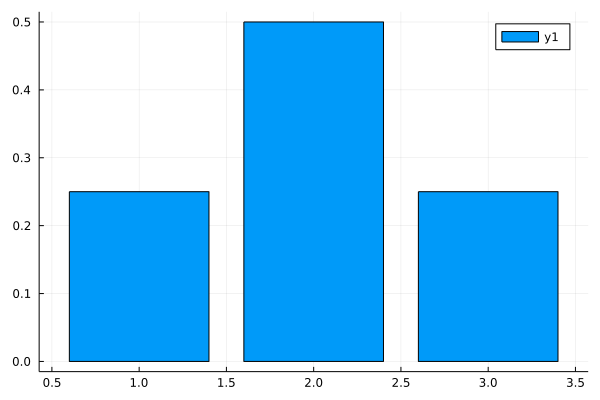

In [61]:
using Plots
bar([0.25, 0.5, 0.25])
# bar chart of PMF

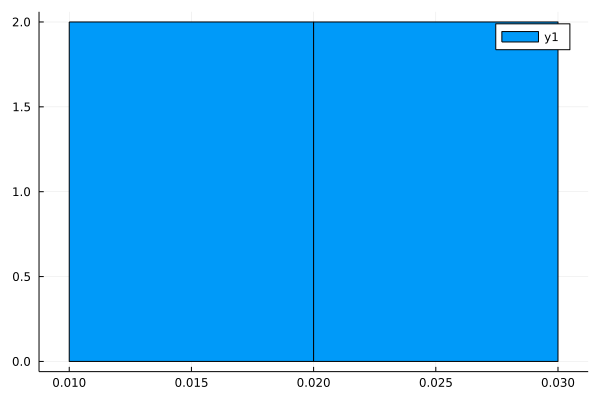

In [62]:
# vs
histogram([0.01, 0.01, 0.02, 0.02])

# A framework for Heterogeneous Agent  models
Suppose agent $i$ has state $x_i$ (discrete)

Aggregate economy is characterized by state $X$

> ### Example
> $x_i \in \{employed, unemployed\}$
> $X =$ fraction of unemployed
> $$ X = \frac 1N\int_i x_i di$$

Note: continuum of agents so that average = expected value. In this case, $X$ is deterministic even though $x_i$ is random.

General Bellman
$$
V(x_i, X) = \max_c
u(c, x_i, X)
+\beta
EV(x_i', X')
$$
with 
$$
X' = F(X)
$$
and
$$
x_i' \sim \text{MC}(\mathbf P(X))
$$

> ### Example
> $$
V_e(X) = w(X) + \beta [
\mu(X)V_u(F(X)) +
(1-\mu(X)) V_e(F(X))
]
$$
>$$
V_u(X) = \max _c b(X) -c + \beta [
\lambda(c, X)V_u(F(X)) +
(1-\lambda(c, X)) V_e(F(X))
]
$$

## In steady state
$F(X)=X$

1. Pick an $X$
2. Solve for the Bellman as if $X$ is known. Standard MCDP
3. Given job search solution, solve for $X'$
4. If different from 1, start again
5. (general rule of thumb) try some convex combination of $X$ and $X'$
	1. Many algo tell you how far you should go

## Without steady state, 

in (1) and (4), pick $F$

in (2) solve for **functional equation** $V_e(X)$, $V_u(X)$


## Special case: agents do not depend on $X$ 
Then Bellman can be solved independently of $X$, and the Markov chain can be characterized as a function of $x_i$ only.

$X$ may still be relevant for aggregate measure.

# Pointers for equilibrium computation
The [Math+Econ+Code courses](http://alfredgalichon.com/coursesandtalks/) of Alfred Galichon.

Equation solving and optimization are the same problem.
$$
F(x) = b
$$
can be solved by minimizing
$$
[F(x)-b]'[F(x)-b].
$$

Judd: [Numerical Methods in Economics](https://kenjudd.org/books/)

Nocedal-Wright: [Numerical Optimization](https://www.csie.ntu.edu.tw/~r97002/temp/num_optimization.pdf)

## Some standard algorithms

[Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

Newton method with step-length selection: Chapter 3 of Nocedal-Wright